# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [3]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1


In [348]:
# Import essential libraries
import pandas as pd
import numpy as np  #
import tensorflow as tf  # for NN Architecture
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import mnist  # To Load Data
from tensorflow.keras.models import Sequential # Model - NN Architecture
from tensorflow.keras.layers import Dense, Flatten # Layers - NN Architecture
from tensorflow.keras.utils import to_categorical # Required Only For Multi-Class Classification problem
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import matplotlib.pyplot as plt # For Visualization

import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, kmeans_plusplus
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
from PIL import Image

from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix


Load the dataset.

In [157]:
# Load and unzip the dataset

# Path to your zip file
zip_file_path = 'data.zip'

# Path where you want to extract the zip file
extract_path = 'CNN_Assignments_images'

# Check if the extract path exists, if not create it
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Zip file extracted successfully.")


# Define the path where our dataset is stored
dataset_path = 'CNN_Assignments_images/data'

# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    if garbage_type not in ('.ipynb_checkpoints','.DS_Store'):
    
        # Verify that the current item is a directory
        if os.path.isdir(folder_path):
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg','png'))]
            
            # Display the count of images in the current folder
            num_images = len(image_files)
            print(f"{garbage_type} folder contains {num_images} images.")
            
            # Loop over each image to check its dimensions
            for image_file in image_files:
                image_path = os.path.join(folder_path, image_file)
                with Image.open(image_path) as img:
                    # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                    width, height = img.size
                    channels = len(img.getbands())
                    all_dimensions_set.add((width, height, channels))
                
# Determine if all images in the entore dataset have the same dimensions 
if len(all_dimensions_set) == 1: 
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")



Zip file extracted successfully.
Cardboard folder contains 540 images.
Food_Waste folder contains 1000 images.
Glass folder contains 750 images.
Metal folder contains 1000 images.
Other folder contains 1010 images.
Paper folder contains 1030 images.
Plastic folder contains 2295 images.

All images in the dataset have the same dimensions: 256x256 with 3 color channels.


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [163]:
# Create a function to load the raw images
def load_images(dataset_directory):
    """
    Load images from a dataset directory where subdirectories represent labels.

    Parameters:
        dataset_directory (str): Path to the directory containing subdirectories of images.

    Returns:
        dict: A dictionary where keys are subdirectory names (labels) and values are lists of loaded images.
    """
    loaded_images_dict = {}

    # Iterate through all subdirectories (labels)
    for label in os.listdir(dataset_directory):
        label_path = os.path.join(dataset_directory, label)

        # Check if it's a directory
        if os.path.isdir(label_path):
            images = []

            # Iterate through all files in the subdirectory
            for filename in os.listdir(label_path):
                if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Check for image file extensions
                    file_path = os.path.join(label_path, filename)

                    # Open and load the image
                    with Image.open(file_path) as img:
                      img_array = np.array(img)

                      # Append the numpy array to the list of images
                      images.append(img_array)

            # Add the list of images to the dictionary
            loaded_images_dict[label] = images

    return loaded_images_dict

In [165]:
# Create a function to load the raw images
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    if garbage_type not in ('.ipynb_checkpoints','.DS_Store'):
        for file in os.listdir(os.path.join(dataset_path, garbage_type)):
            # Append the image file path and its trash type (as a label) to the data list
            data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()


filepath      label
0   CNN_Assignments_images/data\Cardboard\file_1.png  Cardboard
1  CNN_Assignments_images/data\Cardboard\file_10.png  Cardboard
2  CNN_Assignments_images/data\Cardboard\file_100...  Cardboard
3  CNN_Assignments_images/data\Cardboard\file_101...  Cardboard
4  CNN_Assignments_images/data\Cardboard\file_102...  Cardboard

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [169]:
# Get the images and their labels
loaded_images_dict = load_images('CNN_Assignments_images/data')
for label, images in loaded_images_dict.items():
    print(f"Loaded and resize {len(images)} images from label '{label}'.")


Loaded and resize 540 images from label 'Cardboard'.
Loaded and resize 1000 images from label 'Food_Waste'.
Loaded and resize 750 images from label 'Glass'.
Loaded and resize 1000 images from label 'Metal'.
Loaded and resize 1010 images from label 'Other'.
Loaded and resize 1030 images from label 'Paper'.
Loaded and resize 2295 images from label 'Plastic'.


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7625 entries, 0 to 7624
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  7625 non-null   object
 1   label     7625 non-null   object
dtypes: object(2)
memory usage: 119.3+ KB


<Figure size 1000x600 with 0 Axes>

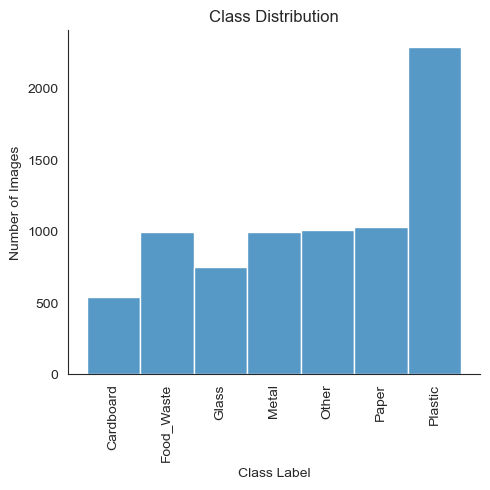

In [176]:
# Visualise Data Distribution
plt.figure(figsize=(10, 6))
sns.displot(df, x="label" )
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels fit within the figure area
plt.show()

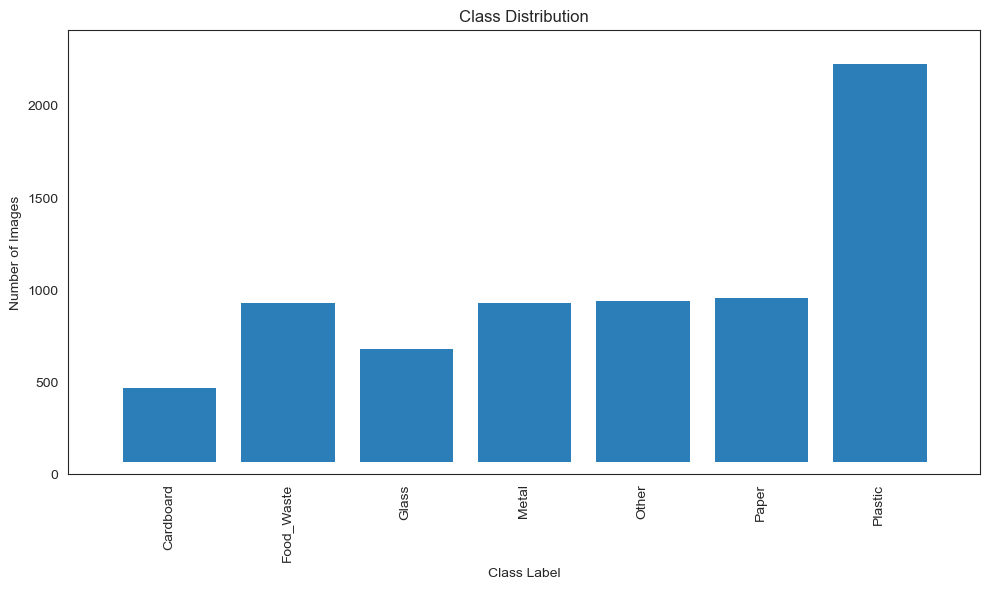

In [178]:
sns.set_style("white")
plt.figure(figsize=(10, 6))
sns.histplot(df, x="label", alpha=.95 , linewidth=18.0)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels fit within the figure area
plt.show()

<Axes: ylabel='count'>

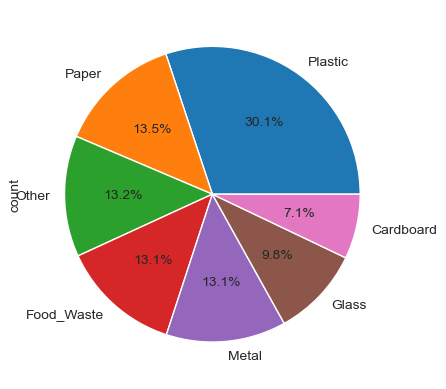

In [180]:
df['label'].value_counts().plot.pie(autopct='%1.1f%%')

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

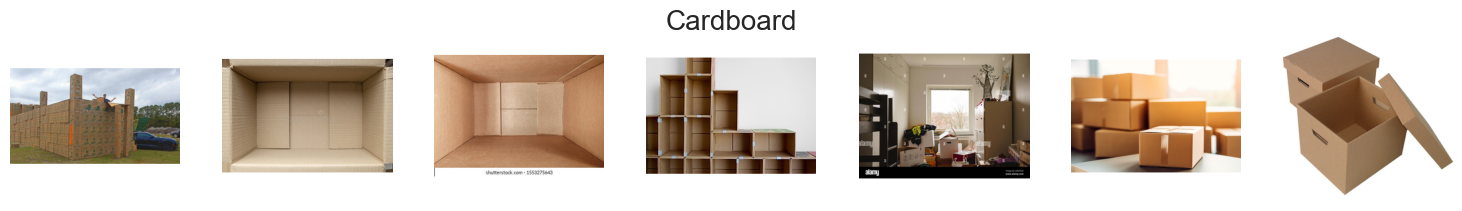

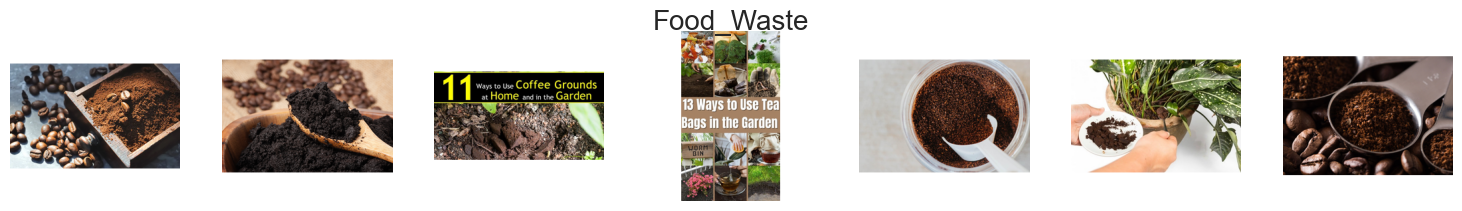

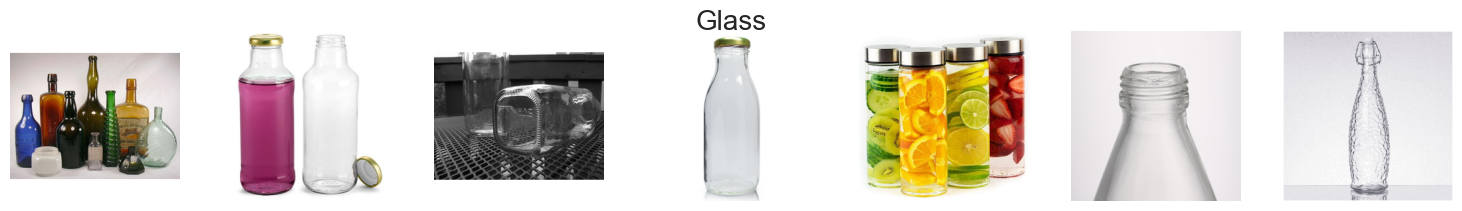

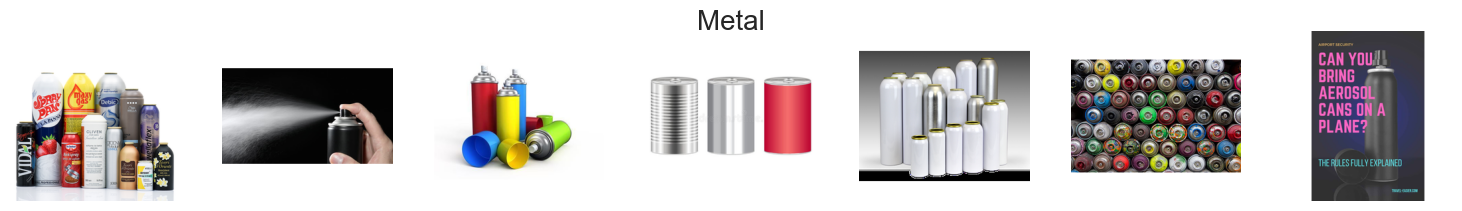

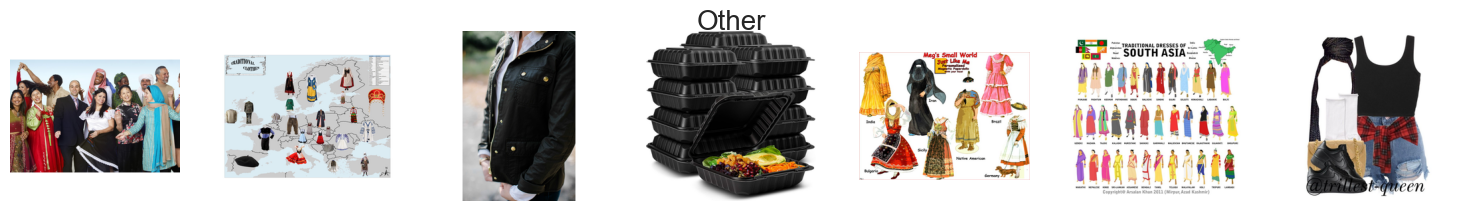

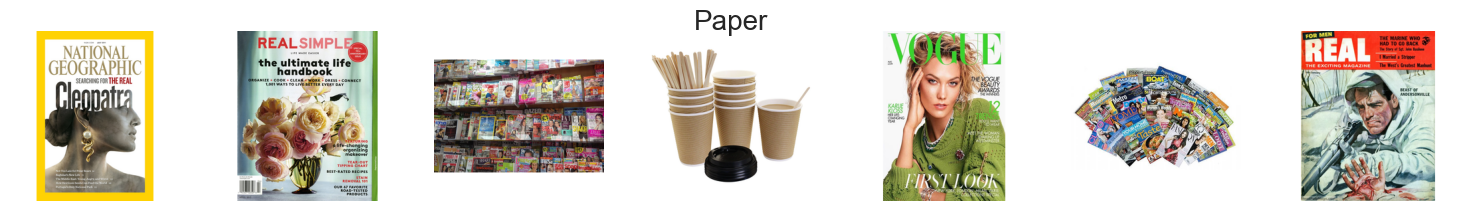

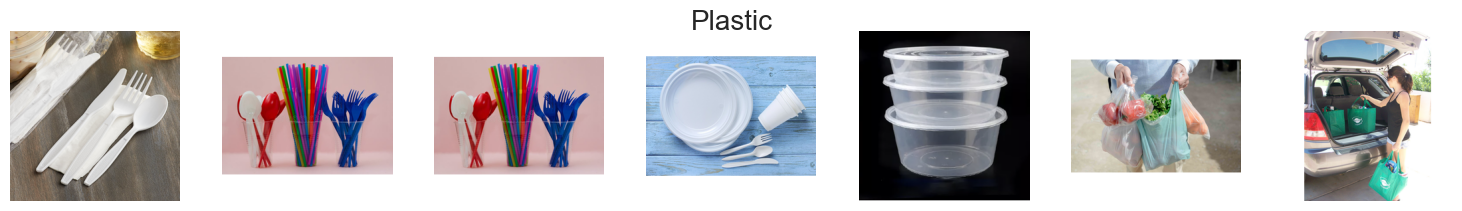

In [183]:
# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    if garbage_type not in ('.ipynb_checkpoints','.DS_Store'):
        # Verify that the current item is a directory
        if os.path.isdir(folder_path):
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg', 'png'))]
            
            # Select the first 10 images
            image_files = image_files[:7]
            
            # Set up subplots
            fig, axs = plt.subplots(1, 7, figsize=(15, 2))
            
            for i, image_file in enumerate(image_files):
                image_path = os.path.join(folder_path, image_file)
                with Image.open(image_path) as img:
                    axs[i].imshow(img)
                    axs[i].axis('off')
            
            plt.tight_layout()
            fig.suptitle(garbage_type, fontsize=20, y=1.03)
            plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [186]:
# Find the smallest and largest image dimensions from the data set

import os
from PIL import Image

#dataset root directory
dataset_path = 'CNN_Assignments_images/data'

# Supported image extensions
valid_extensions = ('.png', '.jpg', '.jpeg')

# Initialize min and max dimensions
min_size = (float('inf'), float('inf'))
max_size = (0, 0)
min_image = max_image = None

# Traverse through all subfolders and files
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(valid_extensions):
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    width, height = img.size

                    # Check for smallest
                    if width * height < min_size[0] * min_size[1]:
                        min_size = (width, height)
                        min_image = file_path

                    # Check for largest
                    if width * height > max_size[0] * max_size[1]:
                        max_size = (width, height)
                        max_image = file_path

            except Exception as e:
                print(f"Skipped {file} due to error: {e}")

# Print results
print(f"Smallest image: {min_image} with size: {min_size[0]}x{min_size[1]}")
print(f"Largest image: {max_image} with size: {max_size[0]}x{max_size[1]}")


Smallest image: CNN_Assignments_images/data\Cardboard\file_1.png with size: 256x256
Largest image: CNN_Assignments_images/data\Cardboard\file_1.png with size: 256x256


In [300]:
# dataset path
dataset_path = 'CNN_Assignments_images/data'

BATCH_SIZE = 64
img_height=256
img_width=256
target_size = (256, 256)
class_mode= "categorical"

# Supported image extensions
valid_extensions = ('.png', '.jpg', '.jpeg')

# Folder to save resized images
save_path = 'CNN_Assignments_images/resized_images'
os.makedirs(save_path, exist_ok=True)

# Counter
count = 0

#dict: A dictionary with resized images.
resized_images_dict = {}

# Loop through dataset
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(valid_extensions):
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    # Convert to RGB (in case of grayscale or RGBA)
                    img = img.convert("RGB")
                    
                    # Resize
                    resized_img = img.resize(target_size)

                    # Optional: maintain folder structure
                    relative_path = os.path.relpath(root, dataset_path)
                    save_folder = os.path.join(save_path, relative_path)
                    os.makedirs(save_folder, exist_ok=True)

                    # Save image
                    resized_img.save(os.path.join(save_folder, file))

                    count += 1

            except Exception as e:
                print(f"Skipped {file} due to error: {e}")

print(f"Completed Resized and saved {count} images to: {save_path}")


Completed Resized and saved 7625 images to: CNN_Assignments_images/resized_images


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

#### **2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [190]:
# Encode the labels suitably

# Collect all images and labels
all_images = []
all_labels = []

for label, images in resized_dataset.items():
    for img in images:
        all_images.append(img)
        all_labels.append(label)

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(all_labels)
print(encoded_labels)

[0 0 0 ... 6 6 6]


In [192]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Path to dataset
dataset_path = 'CNN_Assignments_images/data'

# Step 1: Get image paths and labels
image_paths = []
labels = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            label = os.path.basename(root)  # folder name = label
            image_paths.append(os.path.join(root, file))
            labels.append(label)

# Step 2: Encode labels as integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Step 3 (Optional): One-hot encode
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_labels_1hot = one_hot_encoder.fit_transform(encoded_labels.reshape(-1, 1))

# Display example
print("Classes:", label_encoder.classes_)
print("Encoded:", encoded_labels[:7])
print("One-hot:\n", encoded_labels_1hot[:7])


Classes: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']
Encoded: [0 0 0 0 0 0 0]
One-hot:
 [[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [196]:
# Assign specified parts of the dataset to train and validation sets
from sklearn.model_selection import train_test_split
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_images, encoded_labels, test_size=0.3, random_state=42)
print("Training Images Shape:", X_train.shape)
print("Validation Images Shape:", X_val.shape)
print("Training Labels Shape:", y_train.shape)
print("Validation Labels Shape:", y_val.shape)


Training Images Shape: (5337, 256, 256, 3)
Validation Images Shape: (2288, 256, 256, 3)
Training Labels Shape: (5337,)
Validation Labels Shape: (2288,)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

# **Base Model**

In [322]:
# Set seeds to make the experiment more reproducible.
import random
def seed_everything(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed = 0
seed_everything(seed)

In [328]:
import os
model_path = "model"

os.mkdir(model_path) 
print("Directory '%s' created" %model_path)

train_data_dir = model_path + '/' + 'train'
test_data_dir = model_path + '/' + 'test'

os.mkdir(train_data_dir) 
print("Directory '%s' created" %train_data_dir)
os.mkdir(test_data_dir) 
print("Directory '%s' created" %test_data_dir)


data_path = 'model'
os.listdir(data_path)

Directory 'model' created
Directory 'model/train' created
Directory 'model/test' created


['test', 'train']

In [330]:
input_path = data_path
train_data_dir = input_path + '/' + 'train'
test_data_dir = input_path + '/' + 'test'

#print(train_data_dir)
#print(test_data_dir)

#os.mkdir(train_data_dir) 
#print("Directory '%s' created" %train_data_dir)

#os.mkdir(test_data_dir) 
#print("Directory '%s' created" %test_data_dir)


In [334]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset = 'training',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 7625 files belonging to 7 classes.
Using 6100 files for training.


In [336]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 7625 files belonging to 7 classes.
Using 1525 files for validation.


In [338]:
class_names = train_ds.class_names
print(class_names)

['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [617]:
# Define augmentation steps to augment images



In [350]:
data_augmentation = keras.Sequential([
    #layers.CenterCrop(125, 125),
    layers.RandomFlip('horizontal', input_shape = (img_height, img_width, 3)),
    layers.RandomRotation(0.2, fill_mode = 'nearest'),
    layers.RandomZoom(0.1),
])

C:\Users\siddh\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


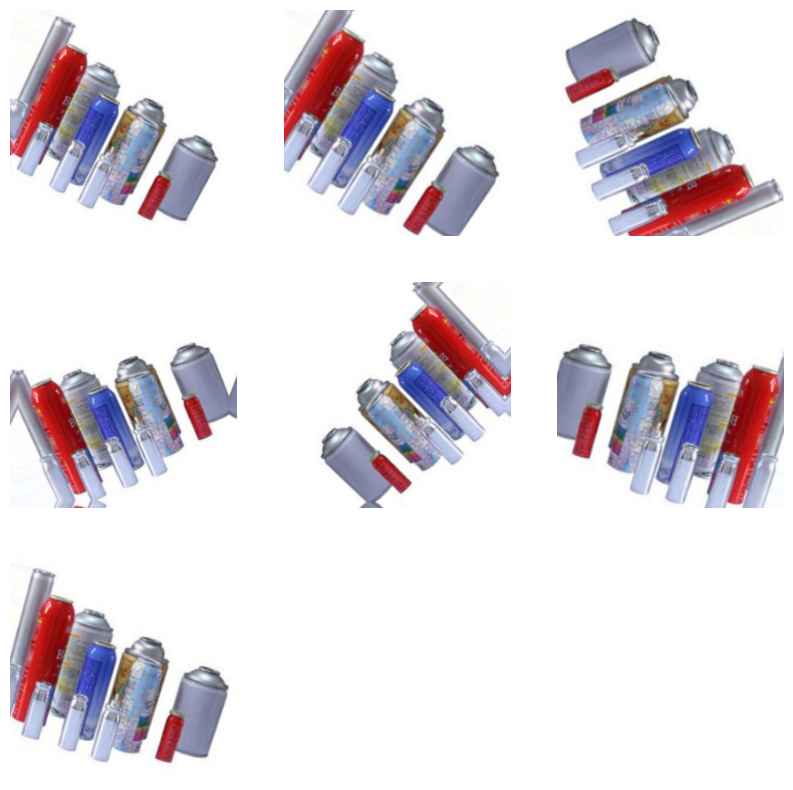

In [352]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
   # plt.title(class_names[2])
    plt.axis("off")

In [354]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

# **Model Architecture**
*   **VGG-16 Base Model**

In [535]:
# Build and compile the model

In [362]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
#base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [364]:
def print_layer_trainable():
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [366]:
print_layer_trainable()

True:	input_layer_2
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [368]:
base_model.trainable = False

In [370]:
for layer in base_model.layers:
    layer.trainable = False

In [372]:
print_layer_trainable()

False:	input_layer_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [374]:
n_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

### **Transfer Learning**


In [377]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,255 (56.39 MB)

 Trainable params: 66,567 (260.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [379]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [602]:
# Model Chackpoint
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'

tl_checkpoint_1 = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [606]:
# Training

In [387]:
%%time
history = model.fit(train_ds,
                    epochs = 20,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1278s 13s/step - accuracy: 0.2760 - loss: 1.9008 - val_accuracy: 0.4118 - val_loss: 1.5007 - learning_rate: 0.0010
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1245s 13s/step - accuracy: 0.4251 - loss: 1.5055 - val_accuracy: 0.5344 - val_loss: 1.2850 - learning_rate: 0.0010
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1228s 13s/step - accuracy: 0.4879 - loss: 1.3739 - val_accuracy: 0.5757 - val_loss: 1.1958 - learning_rate: 0.0010
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1277s 13s/step - accuracy: 0.5363 - loss: 1.2786 - val_accuracy: 0.6144 - val_loss: 1.1300 - learning_rate: 0.0010
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1226s 13s/step - accuracy: 0.5546 - loss: 1.2317 - val_accuracy: 0.6256 - val_loss: 1.0718 - learning_rate: 0.0010
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1235s 13s/step - accuracy: 0.5751 - loss: 1.1891 - val_accuracy: 0.6459 - val_loss: 1.0277 - learning_rate: 0.0010
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1245s 13s/step - accuracy: 0.5898 - loss: 1.

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [610]:
# Evaluate on the test set; display suitable metrics



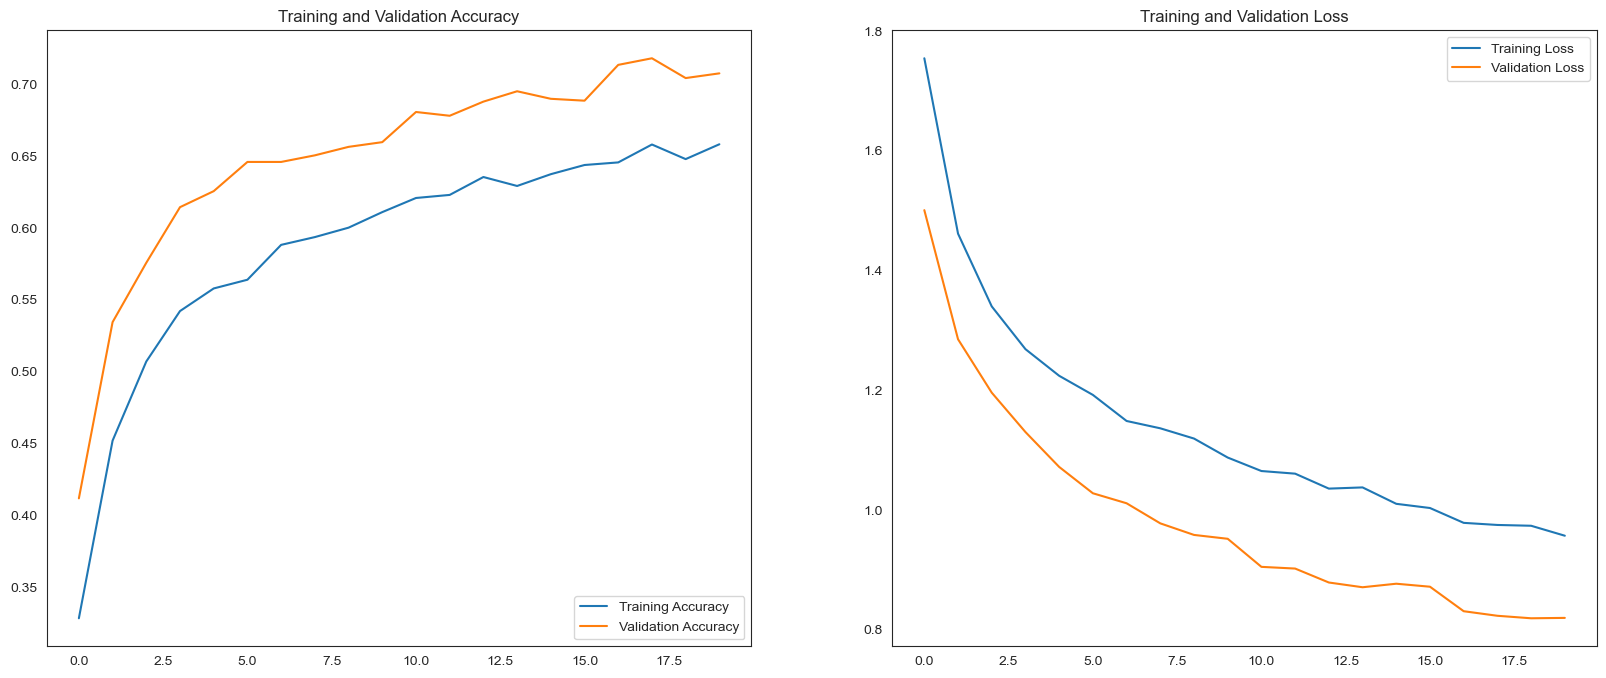

In [389]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

### Creating Training Data

In [420]:
import shutil
data_path = "resized_images"

# path to destination folders
train_folder = os.path.join(data_path, 'train')
val_folder = os.path.join(data_path, 'eval')
test_folder = os.path.join(data_path, 'test')

# Define a list of image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

# Create a list of image filenames in 'data_path'
imgs_list = [filename for filename in os.listdir(data_path) if os.path.splitext(filename)[-1] in image_extensions]


In [436]:
# Sets the random seed 
random.seed(123)

# Shuffle the list of image filenames
random.shuffle(imgs_list)

# determine the number of images for each set
train_size = int(len(imgs_list) * 0.70)
val_size = int(len(imgs_list) * 0.15)
test_size = int(len(imgs_list) * 0.15)


In [438]:
# Create destination folders if they don't exist
for folder_path in [train_folder, val_folder, test_folder]:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Copy image files to destination folders
for i, f in enumerate(imgs_list):
    if i < train_size:
        dest_folder = train_folder
    elif i < train_size + val_size:
        dest_folder = val_folder
    else:
        dest_folder = test_folder
    shutil.copy(os.path.join(data_path, f), os.path.join(dest_folder, f))
    

In [457]:
resized_images_dir="resized_images"
test_ds = tf.keras.utils.image_dataset_from_directory(
    resized_images_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 7625 files belonging to 7 classes.


In [461]:
# Generate predictions
#checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'

#model.load_weights('/content/vgg16_best_weights.hdf5') # initialize the best trained weights

model.load_weights(checkpoint_filepath) # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

7625/7625 ━━━━━━━━━━━━━━━━━━━━ 3110s 408ms/step


In [463]:
model.evaluate(test_ds, verbose = 1)

7625/7625 ━━━━━━━━━━━━━━━━━━━━ 3124s 410ms/step - accuracy: 0.7346 - loss: 0.7557


[0.7761632204055786, 0.7219672203063965]

In [533]:
# Build and compile the model

# **Tuning Model_2**

In [619]:
# Build and compile the model



In [397]:
fine_tune  = base_model

In [399]:
fine_tune.trainable = True

In [401]:
for layer in fine_tune.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [403]:
print_layer_trainable()

False:	input_layer_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [405]:
fine_tune.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [407]:
n_classes = len(class_names)

model2 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    fine_tune,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

In [409]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,255 (56.39 MB)

 Trainable params: 13,045,767 (49.77 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [411]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [515]:
# Model Chackpoint
checkpoint_filepath_1 = '/tmp/ckpt/checkpoint.weights_fine_tuning.h5'
tl_checkpoint_1 = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_1, save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

In [623]:
# Training



In [465]:
%%time
history = model2.fit(train_ds,
                    epochs = 25,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.2445 - loss: 2.0664 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2833s 30s/step - accuracy: 0.2449 - loss: 2.0649 - val_accuracy: 0.3102 - val_loss: 1.8380 - learning_rate: 0.0010
Epoch 2/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 9189s 97s/step - accuracy: 0.3099 - loss: 1.8244 - val_accuracy: 0.3115 - val_loss: 1.8623 - learning_rate: 0.0010
Epoch 3/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.3104 - loss: 1.7923 

96/96 ━━━━━━━━━━━━━━━━━━━━ 3315s 35s/step - accuracy: 0.3105 - loss: 1.7922 - val_accuracy: 0.3298 - val_loss: 1.7511 - learning_rate: 0.0010
Epoch 4/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 59s/step - accuracy: 0.3191 - loss: 1.7572 

96/96 ━━━━━━━━━━━━━━━━━━━━ 6060s 64s/step - accuracy: 0.3192 - loss: 1.7572 - val_accuracy: 0.3580 - val_loss: 1.7246 - learning_rate: 0.0010
Epoch 5/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.3385 - loss: 1.7197 

96/96 ━━━━━━━━━━━━━━━━━━━━ 3476s 36s/step - accuracy: 0.3386 - loss: 1.7196 - val_accuracy: 0.3613 - val_loss: 1.7024 - learning_rate: 0.0010
Epoch 6/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.3648 - loss: 1.6683 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2072s 22s/step - accuracy: 0.3649 - loss: 1.6681 - val_accuracy: 0.3764 - val_loss: 1.6422 - learning_rate: 0.0010
Epoch 7/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.3770 - loss: 1.6084 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2151s 22s/step - accuracy: 0.3770 - loss: 1.6083 - val_accuracy: 0.3770 - val_loss: 1.6136 - learning_rate: 0.0010
Epoch 8/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.3865 - loss: 1.6438 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2098s 22s/step - accuracy: 0.3863 - loss: 1.6438 - val_accuracy: 0.3915 - val_loss: 1.5788 - learning_rate: 0.0010
Epoch 9/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 2099s 22s/step - accuracy: 0.3833 - loss: 1.6040 - val_accuracy: 0.3731 - val_loss: 1.6092 - learning_rate: 0.0010
Epoch 10/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.3996 - loss: 1.5619 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2099s 22s/step - accuracy: 0.3995 - loss: 1.5619 - val_accuracy: 0.3836 - val_loss: 1.5574 - learning_rate: 0.0010
Epoch 11/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 2097s 22s/step - accuracy: 0.3999 - loss: 1.5782 - val_accuracy: 0.4098 - val_loss: 1.5962 - learning_rate: 0.0010
Epoch 12/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.4280 - loss: 1.5091 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2099s 22s/step - accuracy: 0.4280 - loss: 1.5089 - val_accuracy: 0.4485 - val_loss: 1.4834 - learning_rate: 0.0010
Epoch 13/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.4667 - loss: 1.4204 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2098s 22s/step - accuracy: 0.4666 - loss: 1.4206 - val_accuracy: 0.4616 - val_loss: 1.4462 - learning_rate: 0.0010
Epoch 14/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.4869 - loss: 1.3939 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2118s 22s/step - accuracy: 0.4870 - loss: 1.3936 - val_accuracy: 0.4918 - val_loss: 1.3995 - learning_rate: 0.0010
Epoch 15/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5149 - loss: 1.3390 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2124s 22s/step - accuracy: 0.5149 - loss: 1.3391 - val_accuracy: 0.5292 - val_loss: 1.3347 - learning_rate: 0.0010
Epoch 16/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5528 - loss: 1.2625 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2100s 22s/step - accuracy: 0.5527 - loss: 1.2627 - val_accuracy: 0.5259 - val_loss: 1.3019 - learning_rate: 0.0010
Epoch 17/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 2099s 22s/step - accuracy: 0.5574 - loss: 1.2451 - val_accuracy: 0.5134 - val_loss: 1.3531 - learning_rate: 0.0010
Epoch 18/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5739 - loss: 1.1956 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2098s 22s/step - accuracy: 0.5739 - loss: 1.1956 - val_accuracy: 0.5528 - val_loss: 1.2601 - learning_rate: 0.0010
Epoch 19/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5880 - loss: 1.1612 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2131s 22s/step - accuracy: 0.5880 - loss: 1.1612 - val_accuracy: 0.5698 - val_loss: 1.2028 - learning_rate: 0.0010
Epoch 20/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 10620s 111s/step - accuracy: 0.5917 - loss: 1.1457 - val_accuracy: 0.5430 - val_loss: 1.3296 - learning_rate: 0.0010
Epoch 21/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 9129s 96s/step - accuracy: 0.6080 - loss: 1.1202 - val_accuracy: 0.5567 - val_loss: 1.2526 - learning_rate: 0.0010
Epoch 22/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 60s/step - accuracy: 0.6019 - loss: 1.1372  
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
96/96 ━━━━━━━━━━━━━━━━━━━━ 6112s 64s/step - accuracy: 0.6019 - loss: 1.1371 - val_accuracy: 0.5246 - val_loss: 1.2672 - learning_rate: 0.0010
Epoch 23/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.6261 - loss: 1.0539 

96/96 ━━━━━━━━━━━━━━━━━━━━ 3047s 32s/step - accuracy: 0.6262 - loss: 1.0536 - val_accuracy: 0.6026 - val_loss: 1.0974 - learning_rate: 5.0000e-04
Epoch 24/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - accuracy: 0.6442 - loss: 0.9719 

96/96 ━━━━━━━━━━━━━━━━━━━━ 5221s 54s/step - accuracy: 0.6442 - loss: 0.9721 - val_accuracy: 0.6190 - val_loss: 1.0536 - learning_rate: 5.0000e-04
Epoch 25/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 6914s 73s/step - accuracy: 0.6497 - loss: 0.9961 - val_accuracy: 0.5921 - val_loss: 1.1113 - learning_rate: 5.0000e-04
CPU times: total: 4d 11h 19min 56s
Wall time: 1d 2h 29min 59s


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

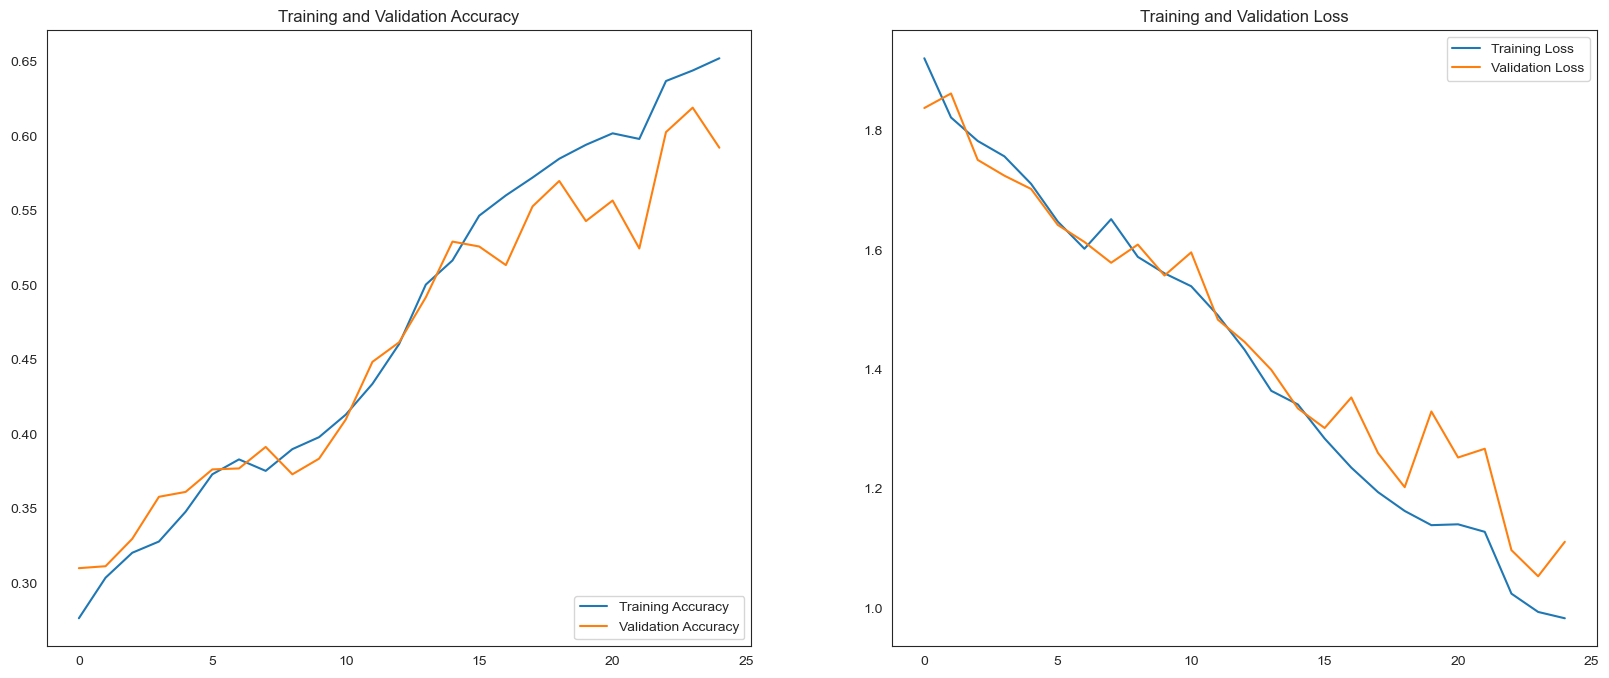

In [469]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [474]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    resized_images_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 7625 files belonging to 7 classes.


In [478]:
# Generate predictions

model2.load_weights(checkpoint_filepath_1) # initialize the best trained weights

preds = model2.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

7625/7625 ━━━━━━━━━━━━━━━━━━━━ 5160s 677ms/step


In [544]:
print(pred_classes)

[5 1 2 ... 0 5 6]


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [492]:
print(pred_classes[:5])

[5 1 2 2 5]


In [480]:
model2.evaluate(test_ds, verbose = 1)

7625/7625 ━━━━━━━━━━━━━━━━━━━━ 7453s 978ms/step - accuracy: 0.6718 - loss: 0.8976


[0.9391148090362549, 0.6540327668190002]

              precision    recall  f1-score   support

           0       0.07      0.08      0.08       180
           1       0.14      0.14      0.14       308
           2       0.09      0.06      0.07       229
           3       0.12      0.10      0.11       289
           4       0.14      0.06      0.08       282
           5       0.18      0.28      0.22       320
           6       0.31      0.34      0.32       680

    accuracy                           0.19      2288
   macro avg       0.15      0.15      0.15      2288
weighted avg       0.18      0.19      0.18      2288



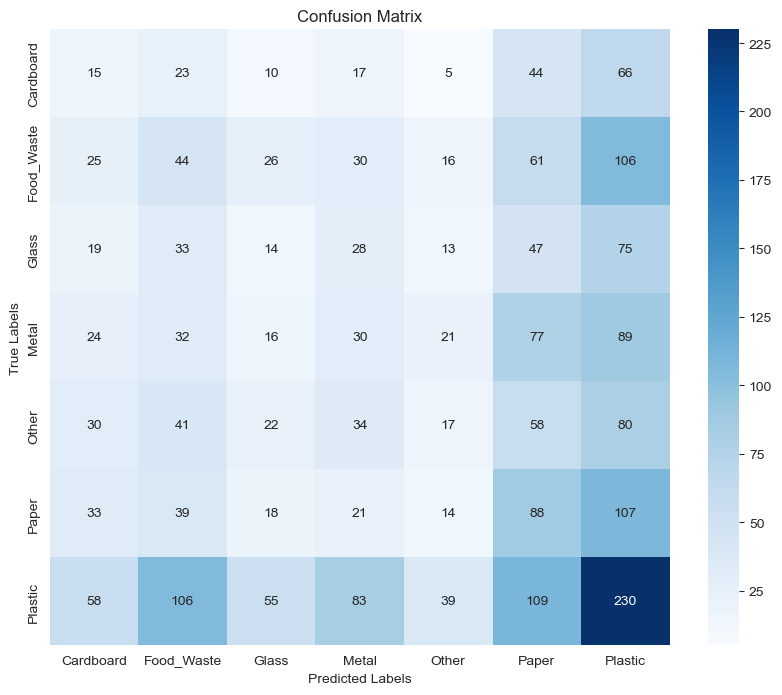

In [653]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report
print(classification_report(y_val[:2288], pred_classes[:2288]))

# Generate confusion matrix
cm = confusion_matrix(y_val[:2288], pred_classes[:2288])

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# **Model_1**

In [507]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

input_shape = X_train.shape[1:] 
num_classes = len(np.unique(y_train))

# Build little bit more simpler model
model_1=Sequential()

#Convolution blocks
model_1.add(Conv2D(32, kernel_size = (3,3), padding='same',input_shape=input_shape,activation='relu'))
model_1.add(MaxPooling2D(pool_size=2))

model_1.add(Conv2D(64, kernel_size = (3,3), padding='same',activation='relu'))
model_1.add(MaxPooling2D(pool_size=2))

model_1.add(Conv2D(32, kernel_size = (3,3), padding='same',activation='relu'))
model_1.add(MaxPooling2D(pool_size=2))

#Classification layers
model_1.add(Flatten())

model_1.add(Dense(64,activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(32,activation='relu'))

model_1.add(Dropout(0.2))
model_1.add(Dense(num_classes,activation='softmax'))


model_1.summary()


C:\Users\siddh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,137,383 (8.15 MB)

 Trainable params: 2,137,383 (8.15 MB)

 Non-trainable params: 0 (0.00 B)

In [517]:
# model_1 Chackpoint 
checkpoint_filepath_1 = '/tmp/ckpt/checkpoint.weights_fine_tuning_M1.h5'
tl_checkpoint_M1 = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_1, save_best_only = True, verbose = 0)

# model_1 EarlyStopping
early_stop_M1 = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

# model_1 ReduceLROnPlateau to stabilize the training process of the model
rop_callback_M1 = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

In [521]:
print(tl_checkpoint_M1)
print(early_stop_M1)
print(rop_callback_M1)

In [523]:
# Training
model_1.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model_1.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=42,
                    batch_size=32,
                    verbose=1,
                    callbacks = [tl_checkpoint_M1, early_stop_M1, rop_callback_M1])

Epoch 1/42
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.2184 - loss: 18.2942

167/167 ━━━━━━━━━━━━━━━━━━━━ 129s 753ms/step - accuracy: 0.2186 - loss: 18.2179 - val_accuracy: 0.3016 - val_loss: 1.8683 - learning_rate: 0.0010
Epoch 2/42
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.2927 - loss: 1.8687

167/167 ━━━━━━━━━━━━━━━━━━━━ 121s 725ms/step - accuracy: 0.2927 - loss: 1.8687 - val_accuracy: 0.3016 - val_loss: 1.8595 - learning_rate: 0.0010
Epoch 3/42
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.3217 - loss: 1.8409

167/167 ━━━━━━━━━━━━━━━━━━━━ 121s 727ms/step - accuracy: 0.3217 - loss: 1.8408 - val_accuracy: 0.3125 - val_loss: 1.8325 - learning_rate: 0.0010
Epoch 4/42
167/167 ━━━━━━━━━━━━━━━━━━━━ 120s 722ms/step - accuracy: 0.3440 - loss: 1.7633 - val_accuracy: 0.3191 - val_loss: 1.8449 - learning_rate: 0.0010
Epoch 5/42
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.3617 - loss: 1.7365

167/167 ━━━━━━━━━━━━━━━━━━━━ 122s 733ms/step - accuracy: 0.3616 - loss: 1.7365 - val_accuracy: 0.3186 - val_loss: 1.8164 - learning_rate: 0.0010
Epoch 6/42
167/167 ━━━━━━━━━━━━━━━━━━━━ 126s 755ms/step - accuracy: 0.3998 - loss: 1.6402 - val_accuracy: 0.3396 - val_loss: 1.8529 - learning_rate: 0.0010
Epoch 7/42
167/167 ━━━━━━━━━━━━━━━━━━━━ 122s 729ms/step - accuracy: 0.4340 - loss: 1.5309 - val_accuracy: 0.3488 - val_loss: 1.9185 - learning_rate: 0.0010
Epoch 8/42
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.4698 - loss: 1.4735
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
167/167 ━━━━━━━━━━━━━━━━━━━━ 123s 734ms/step - accuracy: 0.4698 - loss: 1.4735 - val_accuracy: 0.3527 - val_loss: 1.9503 - learning_rate: 0.0010
Epoch 9/42
167/167 ━━━━━━━━━━━━━━━━━━━━ 124s 745ms/step - accuracy: 0.4958 - loss: 1.3939 - val_accuracy: 0.3479 - val_loss: 2.2381 - learning_rate: 5.0000e-04
Epoch 10/42
167/167 ━━━━━━━━━━━━━━━━━━━━ 140s 729ms/step - accuracy: 0.532

# **model_1** not used in **Conclusion**; it has less val_accuracy compared to accuracy

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

# **1) Base Model :--------** 

## **Accuracy Plot (Left):**
### •Final Accuracies:
#### o Training Accuracy: ~0.66
#### o Validation Accuracy: ~0.71
#### 
### • Insight: Validation accuracy is consistently higher than training accuracy, which is rare and might indicate:
#### o Slight regularization effects
#### o Early stopping or dropout helping avoid overfitting
##### o Or validation set being slightly easier than the training set
####
## **Loss Plot (Right):**
### • Final Losses:
#### o Training Loss: ~0.91
#### o Validation Loss: ~0.83
####
### • Insight: Both losses are decreasing well, and the gap is small, showing good generalization.
####
## **Final Evaluation on Test Set**
## model.evaluate:
#### Loss = 0.7557, Accuracy = 0.7346
#### 0.7762, 0.7220 (presumably another run with similar results)
### • The final test accuracy of approx. 73.5% across 7 classes is a solid performance jump compared to the previous model (approx. 67.1%).
####
## **Conclusion:**
## 1)	Stable training dynamics: Loss and accuracy trends are smooth and consistent.
## 2)	No overfitting: Validation metrics remain better than or close to training metrics.


# **2) Tune Model :--------** 

## **Performance Overview**
### •	Dataset: 7625 images across 7 classes
### •	Final Evaluation Metrics:
#####  o	Validation Accuracy: ~0.735 (73.5%)
#####  o	Validation Loss: ~0.756
### o	Alternate Model Accuracy: ~0.654 (from model2)
###### 
## Training & Validation Curves Analysis
## Accuracy:
### •	The validation accuracy improves steadily and slightly surpasses training accuracy, which indicates good generalization.
### •	The model doesn’t exhibit signs of overfitting, as both curves are close.
## Loss:
### •	Both training and validation loss decrease consistently, with validation loss being slightly lower than training loss in later epochs — a healthy sign.
### •	Smoother convergence indicates stable learning without major fluctuations.
######
## Confusion Matrix Observations
### •	Class Imbalance Insight:
##### o	Some classes like Plastic and Paper are classified more accurately than others.
##### o	Classes such as Cardboard, Food_Waste, and Glass show confusion among similar material types.
### •	Misclassification Patterns:
##### o	Many Plastic instances are misclassified as Food_Waste or Metal — likely due to visual similarities.
##### o	Cardboard vs Paper and Glass vs Metal confusions suggest the model struggles with materials having similar textures or shapes.
###### 

## Key Insights:
### 1.	Model Performance: A validation accuracy of ~73.5% is decent for a 7-class classification problem with potentially overlapping visual features.
### 2.	Confusion Matrix Reveals Scope: Misclassifications suggest some classes need better separation — consider data augmentation or class weighting.
### 3.	Model2 Comparison: Alternate model (model2) performed slightly worse (~65.4% accuracy) — validating that your current model is superior.
### 4.	model shows solid performance and generalization with no signs of overfitting


